## Préambule et fonctions préalables

In [1]:
using Logging
Logging.disable_logging(LogLevel(3))

using LinearAlgebra
using SparseArrays
using KrylovKit
using FFTW
using Plots
using Colors
using IterTools
Threads.nthreads()


(process:5436): GLib-GIO-WARNING **: 11:16:55.113: Unexpectedly, UWP app `draw.io.draw.ioDiagrams_18.0.6.0_x64__1zh33159kp73c' (AUMId `draw.io.draw.ioDiagrams_1zh33159kp73c!draw.io.draw.ioDiagrams') supports 2 extensions but has no verbs


4

In [2]:
function hamiltonian_2D(xmin, xmax, ymin, ymax, Δx, Δx², Δy, Δy², N, N², V, m, ħ)
    # BLOC EXTRA-DIAGONAL
    J = -ħ^2*  1/(2*Δy²)*sparse(I,N,N);
    
    # BLOC DIAGONAL
    diag = -(2/(Δx²) + 2/(Δy²))*ones(Float64,N);  # vecteur de la diagonale
    extra_diag = 1/(Δx²)*ones(Float64,N-1); # vecteur de la sur- et sous-diagonale remplies de 1
    T = -ħ^2/(2*m)* SymTridiagonal(diag, extra_diag);  # matrice des blocs diagonaux, qui est tridiagonale symétrique

    # ASSEMBLAGE DU LAPLACIEN
    Λ = spzeros(N²,N²);
    @views for i in 1:N
        Λ[1+(i-1)*N:i*N,1+(i-1)*N:i*N] .= T[:,:]
    end
    
    @views for i in 1:N-1
        Λ[1+(i-1)* N : i    *N, 1+(i)  *N :  (i+1)*N] .= J[:,:] # remplissage blocs extradiag supérieurs
        Λ[1+(i)  * N : (i+1)*N, 1+(i-1)*N :      i*N] .= J[:,:] # remplissage blocs extradiag inférieurs
    end

    V = Diagonal(reshape(V,N²)); # a priori inutile de convertir en sparse avant

    H = Λ+V;
    H, Λ, V # opérateurs (matrices de taille N²×N²)
end


function hamiltonian_1D(Δd², N, V, m, ħ)
    Λ = -ħ^2/(2*m)*1/(Δd²)*SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1));
    V = sparse(Diagonal(V)); *
    H = Λ + V; 
    H, Λ, V
end

hamiltonian_1D (generic function with 1 method)

In [3]:
xmin=-5.; xmax=5.; ymin=-5.; ymax=5.; N=100; m=1.; M=1.; ω=1.; ħ=1.; kdim=30; # augmenter la dimension Krylov quand N est grand: pour N=200, prendre kdim=50


function V0_fun(x,y)
     return .5*m*ω^2*(x^2+y^2)
end


function Vp_fun(x,y)
     return (3*sin(.5*pi*x+.3*pi*y) + 2*cos(.1*pi*x+pi*y)) #.5*m*ω^2*dot([x-1, y+2], psd*[x+5, y-1]) - .5*m*ω^2*(x^2+y^2)
end



Δx  = (xmax-xmin)/(N-1);
Δy  = (ymax-ymin)/(N-1);
Δx² = Δx*Δx;
Δy² = Δy*Δy;
N²  = N*N;

# CONSTRUCTION DE LA MESHGRID
xs = Vector(xmin:Δx:xmax);
ys = Vector(ymin:Δy:ymax);
X  = ones(N)' .* xs;
Y  = ys' .* ones(N);
V0 = zeros(N,N);
Vp = zeros(N,N);
V  = zeros(N,N);

# CONSTRUCTION DU POTENTIEL ET DU HAMILTONIEN
@. V0 = V0_fun(X, Y);
@. Vp = Vp_fun(X, Y);
Ĥ⁰, ~, V̂⁰ = hamiltonian_2D(xmin, xmax, ymin, ymax, Δx, Δx², Δy, Δy², N, N², V0, m, ħ);
Ĥ,  Λ, V̂  = hamiltonian_2D(xmin, xmax, ymin, ymax, Δx, Δx², Δy, Δy², N, N², V0+Vp, m, ħ);

Ŵ = Diagonal(reshape(Vp, N²));
@show isposdef(Λ);
@show typeof(Ĥ⁰)

isposdef(Λ) = true
typeof(Ĥ⁰) = SparseMatrixCSC{Float64, Int64}


SparseMatrixCSC{Float64, Int64}

## Plot des potentiels

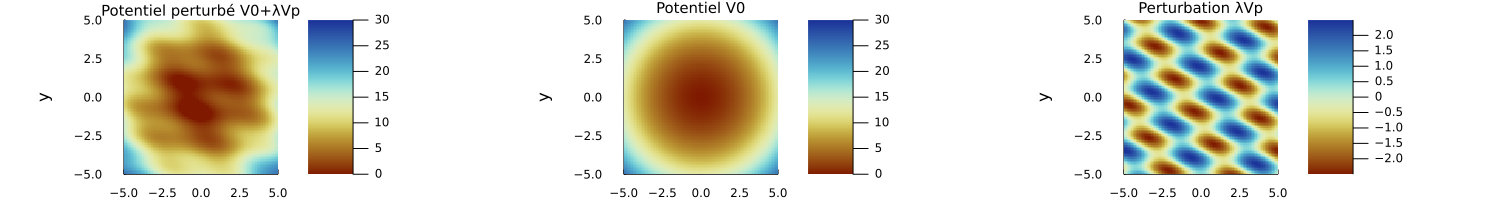

In [4]:
λ = .5;
plot_V  = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), (V0+λ*Vp)', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:roma, rev=false), title = "Potentiel perturbé V0+λVp\n(pour λ=$λ)", grid=true, aspect_ratio=:equal, clims=(0.,30.), titlefontsize=10) 
plot_V0 = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V0', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:roma, rev=false), title = "Potentiel V0", aspect_ratio=:equal, clims=(0.,30.), titlefontsize=10)
plot_Vp = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), λ*Vp', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:roma, rev=false), title = "Perturbation λVp", aspect_ratio=:equal, titlefontsize=10)
plot(plot_V, plot_V0, plot_Vp, layout = (1, 3), legend = false, size=(1500,200))

## Hamiltonien non perturbé (tronqué) numérique

In [6]:
n_modes = 49; # nombre de modes sur lequels on va projeter : mettre un carré parfait
@time lE⁰, lϕ⁰, info_np = KrylovKit.eigsolve(Ĥ⁰, N*N, n_modes, :SR, krylovdim=150);
@show info_np.converged;

  1.927432 seconds (17.52 k allocations: 301.245 MiB, 12.81% gc time)
info_np.converged = 55


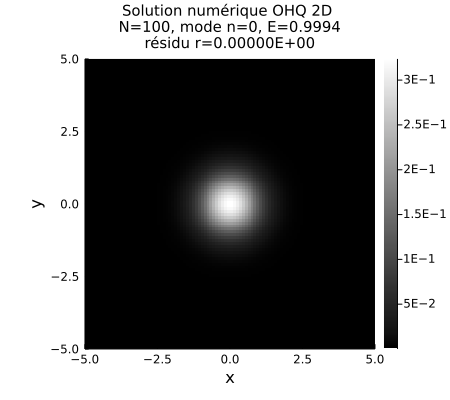

In [7]:
using Printf
mode_numérique = 0;
ψr = lϕ⁰[mode_numérique+1];
densité = N^2/(ymax-ymin)/(xmax-xmin);
heatmap(xs, ys, densité*transpose(reshape(ψr,N,N).^2),
    xlims = (xmin,xmax),
    ylims = (ymin,ymax),
    xlabel="x",
    ylabel="y",
    color=:greys,
    title = "Solution numérique OHQ 2D \nN=$N, mode n=$mode_numérique, E=$(round(lE⁰[mode_numérique+1],digits=4))\nrésidu r="*@sprintf("%.5E",info_np.normres[mode_numérique+1]),
    aspect_ratio=:equal,
    titlefontsize=10,
    size=(450,400))

## Hamiltonien non perturbé analytique

In [12]:
using Polynomials, SpecialPolynomials
x = variable(Polynomial{Rational{Int}})
H = [SpecialPolynomials.basis(Hermite, i)(x) for i in 0:20] # /!\ au décalage d'incice
ϕ1Dω = (n,x,m,ω,ħ) -> (m*ω/ħ)^(.25)*2^(-n/2)*1/sqrt(factorial(n))*π^(-1/4)*H[n+1](sqrt(m*ω/ħ)*x)*exp(-m*ω/2/ħ*x^2);
ϕ1Dk = (n,x,m,k,ħ) -> (k*m)^(.125)/ħ^(.25)*2^(-n/2)*1/sqrt(factorial(n))*π^(-1/4)*H[n+1]((k*m)^(.25)/sqrt(ħ)*x)*exp(-sqrt(k*m)/2/ħ*x^2);

In [13]:
Nx = 7; Ny = 7; 
lϕ⁰e_mat = [@. ϕ1Dω(nx,xs,m,ω,ħ)*ϕ1Dω(ny,xs,m,ω,ħ)' for nx ∈ 0:Nx-1, ny ∈ 0:Ny-1];
lϕ⁰e_vec = reshape([reshape(r,N*N) for r ∈ lϕ⁰e_mat], Nx*Ny)
lE⁰e = [ħ*ω*(1+nx+ny) for nx ∈ 0:Nx-1, ny ∈ 0:Ny-1];
lInd = [(nx,ny) for nx ∈ 0:Nx-1, ny ∈ 0:Ny-1]
discretizedExactStates = sort(reshape(collect(Iterators.zip(lE⁰e,lϕ⁰e_mat,lϕ⁰e_vec,lInd)),Nx*Ny),by=T->T[1][1]);

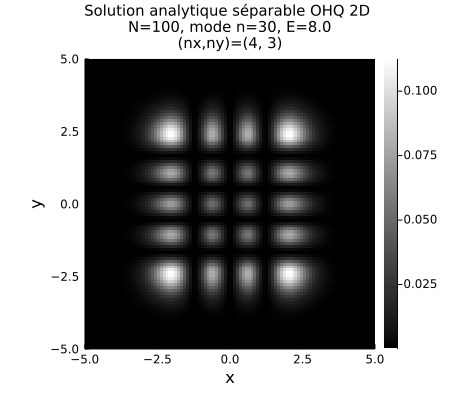

In [14]:
mode_analytique = 30; # le même que le numérique pour comparer

heatmap(xs, ys, discretizedExactStates[mode_analytique+1][2].^2, # pas besoin de normaliser par la densité lorsqu'on plot directement la fonction car c'est la valeur en un point
        xlims = (xmin,xmax),
        ylims = (ymin,ymax),
        xlabel="x",
        ylabel="y",
        color=:greys,
        title = "Solution analytique séparable OHQ 2D \nN=$N, mode n=$mode_analytique, E=$(round(discretizedExactStates[mode_analytique+1][1],digits=4))\n(nx,ny)=$(discretizedExactStates[mode_analytique+1][4])",
        aspect_ratio=:equal,
        titlefontsize=10,
        size=(450,400))

## Comparer les énergies trouvées numériquement avec les énergies analytiques de référence et comparer la bonne orthogonalité entre numérique et analytique échantillonné

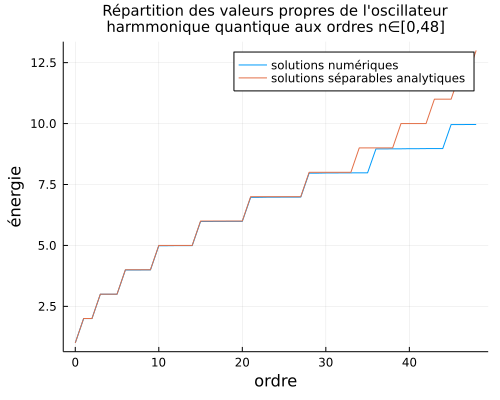

In [42]:
plot(0:n_modes-1,
    [lE⁰[1:n_modes], sort(reshape(lE⁰e[1:n_modes],Nx*Ny))],
    title = "Répartition des valeurs propres de l'oscillateur\nharmmonique quantique aux ordres n∈[0,$(n_modes-1)]", 
    xlabel = "ordre",
    ylabel = "énergie",
    label = ["solutions numériques" "solutions séparables analytiques"],
    titlefontsize = 10,
    size = (500,400))

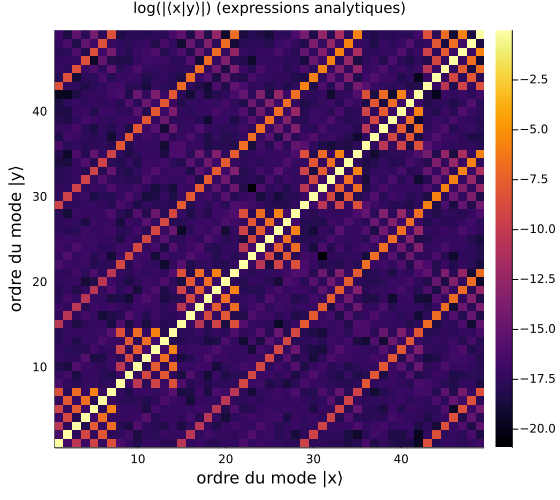

In [16]:
M = reduce(hcat,lϕ⁰e_vec);
densité = (xmax-xmin)*(ymax-ymin)/N^2;
cov_mat = log10.(densité*abs.(M'*M));
heatmap(cov_mat, title="log(|⟨x|y⟩|) (expressions analytiques)", xlabel="ordre du mode |x⟩", ylabel="ordre du mode |y⟩",titlefontsize=10, size=(560,500),right_margin = 3Plots.mm, up_margin = 3Plots.mm)

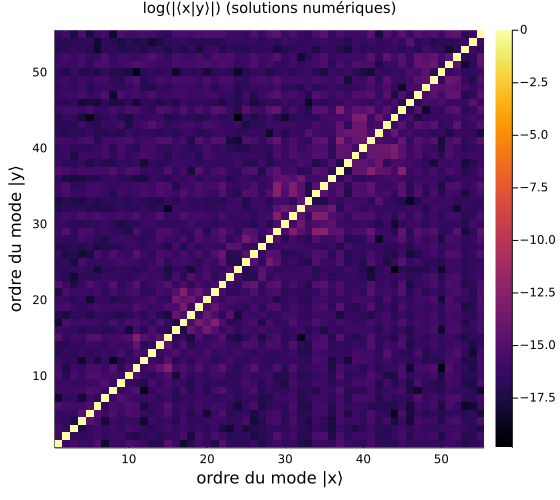

In [43]:
M = reduce(hcat,lϕ⁰);
densité = (xmax-xmin)*(ymax-ymin)/N^2;
cov_mat = log10.(abs.(M'*M));
heatmap(cov_mat, title="log(|⟨x|y⟩|) (solutions numériques)", xlabel="ordre du mode |x⟩", ylabel="ordre du mode |y⟩",titlefontsize=10, size=(560,500),right_margin = 3Plots.mm, up_margin = 3Plots.mm)

## Méthode des perturbations à tout ordre *Sum over states* [à checker]

In [44]:
using Printf
function méthode_perturbations_oq(Ŵ, lε, lϕ, N, ind_approx, λ, qmax, ψr, dim) 
    @assert dim ≤ length(lϕ); # dim: nombre de modes sur lesquels on projette, forcément au plus ceux qu'on a en entrée
    @assert qmax ≤ dim;       # on ne peut pas calculer un ordre supérieur ou égal au nombre de modes dont on dispose
    lΨ  = zeros(N^2, qmax);   # liste des termes-vecteurs ψq pour chaque ordre q ∈ {1,2,...,qmax} pour le vecteur
    lE  = zeros(qmax);        # liste des termes-énergie  Eq pour chaque ordre q ∈ {1,2,...,qmax} pour l'énergie
    lNd = zeros(qmax);        # liste des normes 2 des différences entre solution de référence et chaque approximation à l'ordre q
    mA   = zeros(dim,qmax);   # matrice des αiq,décomposition des (ψq = Σ_i∈1:dim αiq.ϕi) dans la base des ϕᵢ pour chaque ordre q ∈ {1,2,...,qmax} 

    lϕ  = reduce( # conversion de lϕ de Vector{Vector{Float64}} vers Matrix{Float64}
                hcat,
                collect(lϕ[1:dim]));
    
    ϕHBO = reshape(lϕ[:,ind_approx+1],N*N); # état propre HBO; correspond à ϕ_j dans les équations
    EHBO = lε[ind_approx+1]; # énergie propre HBO
    ψc   = zeros(N*N); # vecteur corrigé  avec la théorie des perturbations
    Ec   = 0;          # énergie corrigée avec la théorie des perturbations
    ψc   += ϕHBO;
    Ec   += EHBO;

    # terme énergie au premier ordre
    lE[1] = ϕHBO'*Ŵ*ϕHBO;
    Ec += λ*lE[1];

    # terme vecteur au premier ordre
    for k=1:dim # sum over states
        α1k  = (k == ind_approx+1) ? 0 : -1/(lε[k] - EHBO) * lϕ[:,k]'*Ŵ*ϕHBO; # formule B-11 du Cohen-Tanoudji, chapitre 11, page 1127 ou voir également poly Cances exo 8.1
        ### A[k,1] =  α1k; # on sauvegarde le coef de l'ordre 1 sur le vecteur ϕk
        lΨ[:,1] += α1k * lϕ[:,k]; # on update ψ1 dans la liste des vecteurs à tout ordre
    end
    ψc += λ*lΨ[:,1];
    # ψc = ψc/norm(ψc);
    lNd[1] = norm(ψc - ψr)/densité;
    



    ŴmE1 = Ŵ .- Diagonal(lE[1]*ones(N*N));

    
    for q=2:qmax
    # terme énergie à l'ordre q ≥ 2 D'ABORD
        lE[q] = ϕHBO'*ŴmE1*lΨ[:,q-1] - sum([lE[r] * ϕHBO' * lΨ[:,q-r] for r in 2:q-1])
        Ec += (λ^q)*lE[q];
    # terme vecteur à l'ordre q ≥ 2
        for k=1:dim
            αqj = -1/2*sum([lΨ[:,r]'*lΨ[:,q-r] for r in 1:q-1]);
            αqknj = -1/(lε[k] - EHBO)*( - lϕ[:,k]'*ŴmE1*lΨ[:,q-1] + sum([lE[r] * lϕ[:,r]'*lΨ[:,q-r] for r in 2:q-1]) + lE[q]*lϕ[:,q]' * ϕHBO);
            αqk = (k == ind_approx+1) ? αqj : αqknj;
            # formule 2.43 ou 2.48 de mon rapport suivant le test
            ### A[k,q] = αqk; # on sauvegarde la composante de l'ordre q sur le vecteur ϕk
            lΨ[:,q] += αqk * lϕ[:,k]; # on update ψq dans la liste des vecteurs à tout ordre
        end
        ψc += λ^q*lΨ[:,q];
        # ψc = ψc/norm(ψc);
        lNd[q] = norm(ψc - ψr)/densité;
    end
    

    @views mA[:,:] = lϕ'*lΨ*Diagonal([λ^q for q ∈ 1:qmax]); # enfin, puisque les ϕᵢ sont orthogonaux entre eux (théoriquement),
                            # on calcule les coefficients αiq, i.e. projeté de chaque Ψ sur les ϕᵢ
    return ϕHBO, EHBO, lϕ, lε, ψc, Ec, lΨ, lE, mA, lNd
end

méthode_perturbations_oq (generic function with 1 method)

In [45]:
# paramètres
qmax = 10; λ = .1;
ind_approx = 0;
densité = N^2/(ymax-ymin)/(xmax-xmin);



# on calcule la référence simulée pour le hamiltonien perturbé coefficienté de λ
@time lE_ref, lϕ_ref, info = KrylovKit.eigsolve(Ĥ⁰+λ*Ŵ, N*N, ind_approx+1, :SR, krylovdim=40);
@show info.converged;
Γ_ref    = reshape(lϕ_ref[ind_approx+1],N,N); # référence



# on calcule l'état avec la sum over states en théorie des perturbations
ϕHBO, EHBO, lϕ, lε, ψc, Ec, lΨ, lE, mA, lNd = méthode_perturbations_oq(Ŵ, lE⁰, lϕ⁰, N, ind_approx, λ, qmax, lϕ_ref[ind_approx+1], 30); # je projette sur 30 modes max
Γ_sum_st = reshape(ψc,N,N); # sum over states





dist_ref = round(norm(Γ_ref+Γ_sum_st)/densité,digits=6) # norme 2 de la différence entre les deux modes, celui de la sum over states et celui de la réféfence calculé en 2D. 


plot_prob_sum_st = heatmap(xs, ys, densité*transpose(Γ_sum_st).^2,
        color=:greys,
        aspect_ratio=:equal,
        xlim=[xmin,xmax], ylim=[ymin, ymax],
        titlefontsize=8,
        xlabel='x', ylabel='y',
        title = "Densité proba de H⁰+λW approchée (mode $ind_approx)\nth. des pert. à l'ordre $qmax par Born-Oppenheimer\nÉnergie E=$(round(Ec,digits=5))\nDistance-référence $(@sprintf("%.3E",dist_ref))");

plot_prob_ref = heatmap(xs, ys, densité*transpose(Γ_ref).^2,
        color=:greys,
        aspect_ratio=:equal,
        xlim=[xmin,xmax], ylim=[ymin, ymax],
        titlefontsize=8,
        xlabel='x', ylabel='y',
        title = "Densité proba de H⁰+λW référence (mode $ind_approx)\n résol. '2D en coordonnées généralisées' \nÉnergie E=$(round(lE_ref[ind_approx+1],digits=4))");



plot_vec_sum_st = heatmap(xs, ys, transpose(Γ_sum_st),
        xlims = (xmin,xmax), ylims = (ymin,ymax),
        xlabel="x", ylabel="y",
        color=cgrad(:Spectral, rev=false),
        title = "Vecteur de H⁰+λW approchée (mode $ind_approx)\nth. des pert. à l'ordre $qmax par Born-Oppenheimer",
        aspect_ratio=:equal,
        titlefontsize=8,);

plot_vec_ref = heatmap(xs, ys, transpose(Γ_ref),
        xlims = (xmin,xmax), ylims = (ymin,ymax),
        xlabel="x", ylabel="y",
        color=cgrad(:Spectral, rev=false),
        title = "Vecteur de H⁰+λW référence (mode $ind_approx)\n résol. '2D en coordonnées généralisées'",
        aspect_ratio=:equal,
        titlefontsize=8);

# plot(plot_prob_sum_st, plot_prob_ref, plot_vec_sum_st, plot_vec_ref, layout = (1, 4), legend = false, size=(1800,350))


coeffs_contamination = heatmap(log10.(abs.(mA)),
        aspect_ratio=:auto,
        xlabel="ordre de la perturbation q",
        ylabel="indice mode non perturbé k",
        title="coeff contamination log₁₀(λ^q⋅⟨ψq|ϕk⟩)",
        titlefontsize=11);

norm_terme_ordre = scatter([log10.([norm(mA[:,q]) for q in 1:qmax]) log10.(lNd)],
    label = ["norme terme ordre q" "norme erreur"],
    legend = true,
    xlabel="ordre de la perturbation q", ylabel = "log₁₀(λ^q⋅⟨ψq|ψq⟩)",
    titlefontsize=11, 
    title="norme du terme d'ordre ψq (bleu)\nnorme de la différence à la référence (rouge)");


# plot(coeffs_contamination, norm_terme_ordre, layout = (1, 2), legend = false, size=(1000,350),right_margin = 10Plots.mm, left_margin = 10Plots.mm, bottom_margin = 8Plots.mm, top_margin = 8Plots.mm)

plot(coeffs_contamination, norm_terme_ordre, plot_prob_sum_st, plot_prob_ref, plot_vec_sum_st, plot_vec_ref, plot_V, plot_V0, layout = (4, 2), legend = false, size=(1000,1300),right_margin = 3Plots.mm, left_margin = 3Plots.mm, bottom_margin = 1Plots.mm, top_margin = 1Plots.mm)
savefig("./myhistogram.pdf") # dans le dossier du notebook

  0.099123 seconds (2.81 k allocations: 44.864 MiB, 13.79% gc time)
info.converged = 1


### Automatisation calcul projecteur

In [13]:
Hp_gpu = CUDA.CUSPARSE.CuSparseMatrixCSC{Float32}(Ĥ⁰+.4*Ŵ); # ok 
@show typeof(Hp_gpu);
@time lE_ref, lϕ_ref, info = KrylovKit.eigsolve(Hp_gpu, N*N, 3, :SR, krylovdim=3); # pas ok: scalar indexing

typeof(Hp_gpu) = CUDA.CUSPARSE.CuSparseMatrixCSC{Float32, Int32}


In [ ]:
X = V'*V*lE; # les Vij du livre

### Tests pour le calcul du projecteur

In [8]:
λ = .6;
H = Ĥ⁰+λ*Ŵ - .1*exp(2*im)*Diagonal(Matrix(I, N², N²));
@show typeof(H);
@show size(H);
@show sizeof(H);
@show isposdef(H);

# calculer sa plus grande valeur propre et sa plus petite
@time lE_LM, ~, info = KrylovKit.eigsolve(Ĥ⁰+λ*Ŵ, N*N, 1, :LM);
@show info.converged;
@show lE_LM[1];

@time lE_SR, ~, info = KrylovKit.eigsolve(Ĥ⁰+λ*Ŵ, N*N, 1, :SR);
@show info.converged;
@show lE_SR[1];

# estimer son conditionnement
# @time F = ldlt(H)
# majorant du conditionnement cf https://scicomp.stackexchange.com/questions/32762/cholmod-condition-number-estimate et lien entre décomposition de Chleski et ldlt
# findmax(abs.(diag(F)))[1]/findmin(abs.(diag(F)))[1] 

typeof(H) = SparseMatrixCSC{ComplexF64, Int64}
size(H) = (10000, 10000)
sizeof(H) = 40
isposdef(H) = false
  0.033825 seconds (1.15 k allocations: 22.455 MiB)
info.converged = 1
lE_LM[1] = 445.66418164279133
  0.085622 seconds (2.55 k allocations: 47.846 MiB, 14.78% gc time)
info.converged = 1
lE_SR[1] = 0.2582333802541156


0.2582333802541156

In [89]:
F = cholesky(H)
(findmax(abs.(diag(F)))[1]/findmin(abs.(diag(F)))[1])^2 

PosDefException: PosDefException: matrix is not positive definite; Cholesky factorization failed.

In [59]:
using CUDA;
r_cpu = Hermitian(Tridiagonal{ComplexF32}((-1.2-0.1*im)*ones(22499),(3.4+0.0*im)*ones(22500),(-1.2+0.1*im)*ones(22499)));
s_cpu = Hermitian(Tridiagonal{ComplexF32}((-1.0-0.4*im)*ones(22499),(4.5+0.0*im)*ones(22500),(-1.0+0.4*im)*ones(22499)));

r_gpu = CUDA.CUSPARSE.CuSparseMatrixCSR{ComplexF32}(sparse(r_cpu));
s_gpu = CUDA.CUSPARSE.CuSparseMatrixCSR{ComplexF32}(sparse(s_cpu));

@show typeof(r_gpu);

typeof(r_gpu) = CUDA.CUSPARSE.CuSparseMatrixCSR{ComplexF32, Int32}


CUDA.CUSPARSE.CuSparseMatrixCSR{ComplexF32, Int32}

In [13]:
using CUDA;
using CUDA.CUSPARSE;
using SparseArrays;

N = convert(Cint,10);

r_cpu = sprand(N,N,.2);
s_cpu = sprand(N,N,.2);


r_gpu = CUDA.cu(r_cpu);
s_gpu = CUDA.cu(s_cpu); # produit ne fonctionne pas

r_gpu = CuSparseMatrixCSC(r_cpu);
s_gpu = CuSparseMatrixCSC(s_cpu); # produit ne fonctionne pas: https://github.com/JuliaGPU/CUDA.jl/issues/1113#issuecomment-955759875

r_gpu = CuArray(r_cpu);
s_gpu = CuArray(s_cpu); # produit fonctionne

@show typeof(r_cpu);
@show typeof(r_gpu);

typeof(r_cpu) = SparseMatrixCSC{Float64, Int64}
typeof(r_gpu) = CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}


In [14]:
CUDA.@time r_gpu * s_gpu;

  0.001275 seconds (68 CPU allocations: 3.797 KiB) (1 GPU allocation: 800 bytes, 0.94% memmgmt time)


In [24]:
CUDA.device_reset!()
CUDA.reclaim()
CUDA.memory_status()

Effective GPU memory usage: 32.82% (1.313 GiB/4.000 GiB)
Memory pool usage: 457.764 MiB (576.000 MiB reserved)

In [125]:
CUDA.Mem.free

free (generic function with 4 methods)

### Cholesky

In [22]:
using LinearAlgebra;
using CUDA;
r_gpu = nothing; 
h_gpu = nothing;
CUDA.reclaim()
N = 6000;
r_gpu = CUDA.rand(Float32, N, N);
h_gpu = (r_gpu * r_gpu')/2;
h_gpu = h_gpu + h_gpu' + CuArray(Diagonal(ones(N)));
CUDA.@time cholesky(h_gpu);

  0.886957 seconds (215 CPU allocations: 12.844 KiB) (5 GPU allocations: 274.658 MiB, 0.00% memmgmt time)


In [11]:
using CUDA;
m_gpu = nothing;
CUDA.reclaim()
N = 100;
m_gpu = CUDA.rand(Float32, N, N);
CUDA.@time m_gpu, ipiv, info = CUDA.CUSOLVER.getrf!(m_gpu)

  0.004102 seconds (76 CPU allocations: 4.578 KiB) (3 GPU allocations: 18.020 KiB, 1.04% memmgmt time)


(Float32[0.9865547 0.15667458 … 0.48477137 0.9672704; 0.5778846 0.9036207 … 0.22312132 -0.021856405; … ; 0.058431312 0.011268336 … -1.1242752 -1.5397397; 0.31960613 0.04336785 … 0.21404068 0.85362047], Int32[62, 27, 25, 36, 93, 71, 26, 66, 69, 22  …  91, 92, 95, 98, 96, 99, 99, 99, 100, 100], 0)

In [1]:
using CUDA;
using LinearAlgebra;
N = 3000;
elty = Float32;
A          = rand(elty,N,N)
d_A        = CuArray(A)
d_A,d_ipiv,info = CUSOLVER.getrf!(d_A)
B          = rand(elty,N,N)
d_B        = CuArray(B)
CUDA.@time d_B        = CUSOLVER.getrs!('N',d_A,d_ipiv,d_B)
h_B        = collect(d_B)
@time h_B_cpu = A\B;
@show info;
@show h_B  ≈ h_B_cpu;
@show norm(A*h_B_cpu-B);
@show norm(A*h_B-B);

  0.181179 seconds (194.23 k CPU allocations: 10.326 MiB) (1 GPU allocation: 4 bytes, 0.02% memmgmt time)
  1.068606 seconds (2.80 M allocations: 213.203 MiB, 9.53% gc time, 72.68% compilation time)
info = 0
h_B ≈ h_B_cpu = false
norm(A * h_B_cpu - B) = 4.0975385f0
norm(A * h_B - B) = 5.3139095f0


┌ Warning: Unable to use CUDA from artifacts: The artifact at C:\Users\matth\.julia\artifacts\fd3b38cf5ade69a121c1ed6bc7a0a47f930ac0a1 is empty.
│ This is probably caused by a failed download. Remove the directory and try again.
└ @ CUDA.Deps C:\Users\matth\.julia\packages\CUDA\GGwVa\deps\bindeps.jl:84


In [57]:
using LinearAlgebra
norm(h_B-h_B_cpu)/N/N

1.2013751f-5

In [23]:
N = 6000;
r_cpu = rand(Float32, N, N);
h_cpu = r_cpu * r_cpu'
h_cpu = h_cpu + h_cpu' + Diagonal(ones(N));
@time cholesky(h_cpu);

  0.706001 seconds (5 allocations: 274.658 MiB, 2.70% gc time)


In [ ]:
# on calcule la référence simulée pour le hamiltonien perturbé coefficienté de λ
eig_vap, eig_vec, info = KrylovKit.eigsolve(r_gpu, N, 5, :SR, krylovdim=10);

In [16]:
H_gpu = CuArray(Ĥ⁰+.3*Ŵ);
CUDA.@time H_gpu * H_gpu;

 22.454787 seconds (1.54 M CPU allocations: 82.444 MiB, 0.33% gc time) (1 GPU allocation: 762.939 MiB, 0.01% memmgmt time)


In [19]:
H_cpu = Ĥ⁰+.3*Ŵ;
@time H_cpu*H_cpu;

  0.001160 seconds (8 allocations: 4.363 MiB)


In [64]:
cond(Array(Ĥ⁰),2)

In [5]:
F = ldlt(Λ+V̂⁰ - 4*Diagonal(Matrix(I, N*N, N*N)))

SuiteSparse.CHOLMOD.Factor{Float64}
type:    LDLt
method:  simplicial
maxnnz:  513777
nnz:     206332
success: true


In [7]:
findmax(abs.(diag(F)))[1]/findmin(abs.(diag(F)))[1] # calcul du conditionnement

434.6700945997285